# Préparation des Données

### Librairies à importer

In [7]:
import pandas as pd
import numpy as np
import plotly.express as px
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.ensemble import IsolationForest
from sklearn.metrics import silhouette_score, silhouette_samples, normalized_mutual_info_score

### Chargement du fichier CSV

In [8]:

file_path = 'Data_Arbre.csv'
data = pd.read_csv(file_path, sep=",", header=0)

# Apprentissage Non Supervisé

### Algorithme de clustering K-Means

In [9]:
col_data = data[['haut_tot', 'haut_tronc', 'tronc_diam']]
n = 5
kmeans = KMeans(n_clusters=n, random_state=42)
data['cluster'] = kmeans.fit_predict(col_data)

### Plot des colonnes numériques

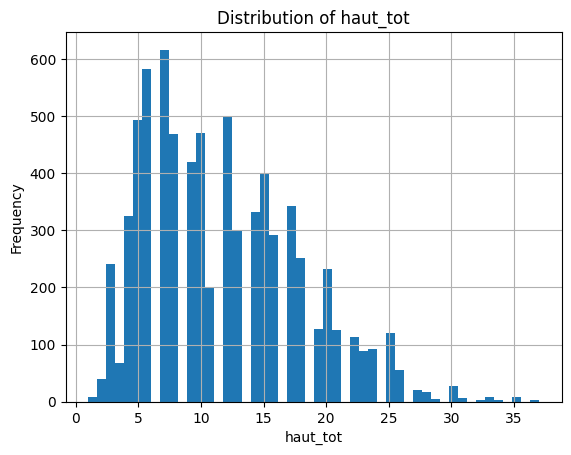

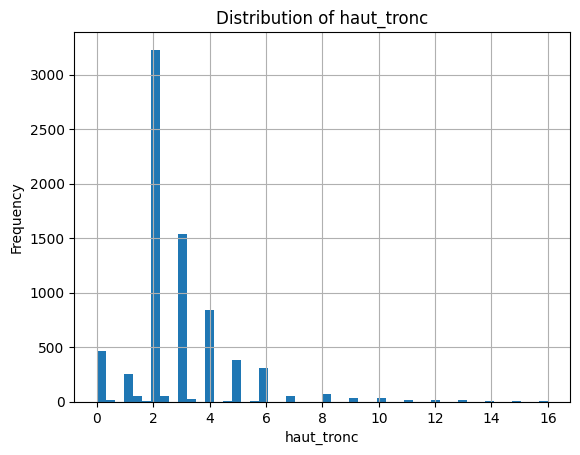

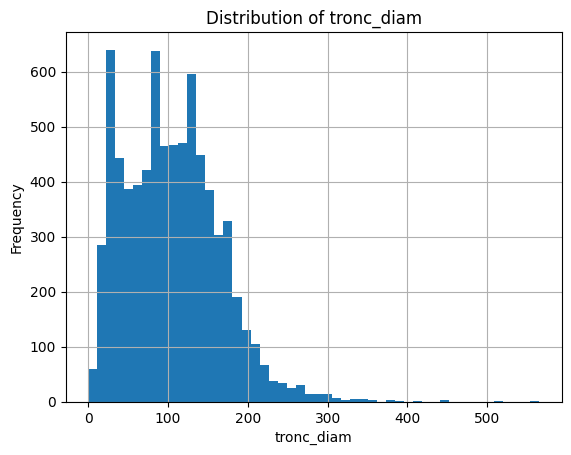

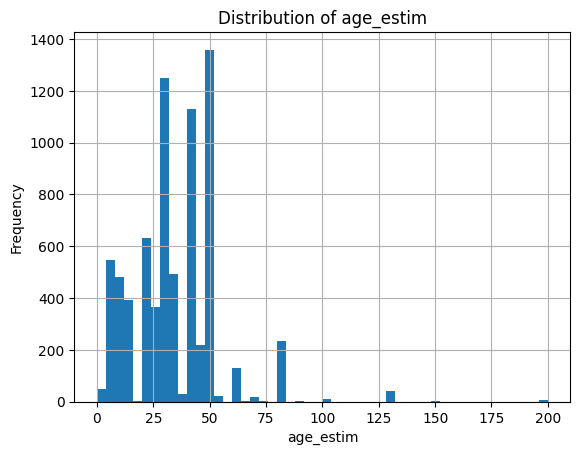

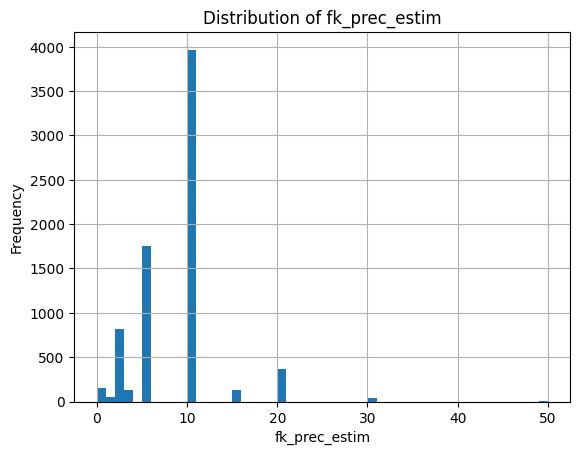

In [10]:
num_col = ['haut_tot', 'haut_tronc', 'tronc_diam', 'age_estim', 'fk_prec_estim']
for col in num_col:
    plt.figure()
    data[col].hist(bins=50)
    plt.title(f'Distribution of {col}')
    plt.xlabel(col)
    plt.ylabel('Frequency')
    plt.show()

### Algorithme de détection d'anomalies Isolation Forest

In [11]:
ano_data = data[['haut_tronc', 'tronc_diam', 'age_estim', 'fk_prec_estim']]
iso_forest = IsolationForest(contamination=0.05, random_state=42)
data['anomaly'] = iso_forest.fit_predict(ano_data)
data['anomaly'] = data['anomaly'].apply(lambda x: 'Anomalie' if x == -1 else 'Normal')

# Métriques pour l'Apprentissage Non Supervisé

### Évaluation du clustering avec plusieurs métriques


In [12]:
silhouette_avg = silhouette_score(col_data, data['cluster'])
nmi_avg = normalized_mutual_info_score(data['tronc_diam'], data['cluster'])
print(f"Indice de silhouette moyen : {silhouette_avg}")
print(f"Indice de NMI moyen : {nmi_avg}")

Indice de silhouette moyen : 0.5234870514588814
Indice de NMI moyen : 0.47372983702046767


### Déterminer le nombre optimal de clusters


In [13]:
distortions = []
silhouette_scores = []
K = range(2, 11)
for k in K:
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(col_data)
    distortions.append(kmeans.inertia_)
    silhouette_scores.append(silhouette_score(col_data, kmeans.labels_))

### Plot du coefficient de silhouette


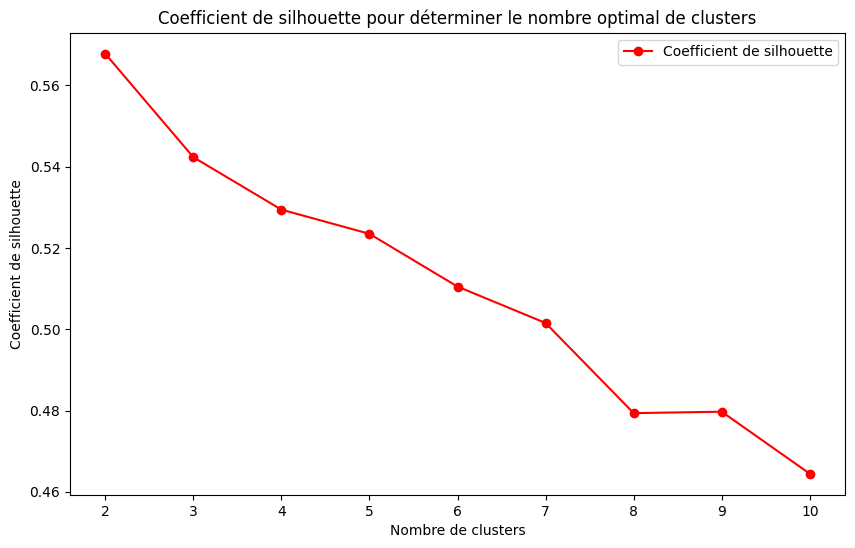

In [14]:
plt.figure(figsize=(10, 6))
plt.plot(K, silhouette_scores, 'ro-', label='Coefficient de silhouette')
plt.title('Coefficient de silhouette pour déterminer le nombre optimal de clusters')
plt.xlabel('Nombre de clusters')
plt.ylabel('Coefficient de silhouette')
plt.legend()
plt.show()

### Plot de la méthode du coude


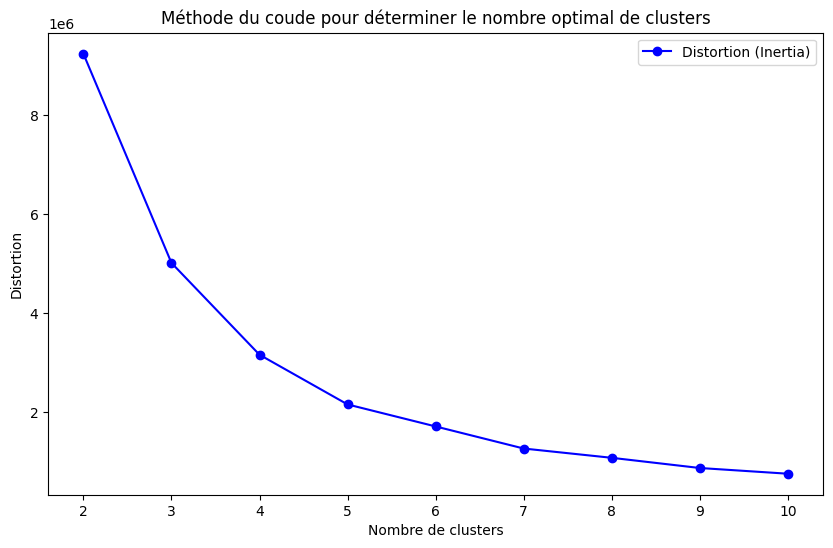

In [15]:
plt.figure(figsize=(10, 6))
plt.plot(K, distortions, 'bo-', label='Distortion (Inertia)')
plt.title('Méthode du coude pour déterminer le nombre optimal de clusters')
plt.xlabel('Nombre de clusters')
plt.ylabel('Distortion')
plt.legend()
plt.show()

### Création du graphique d'analyse


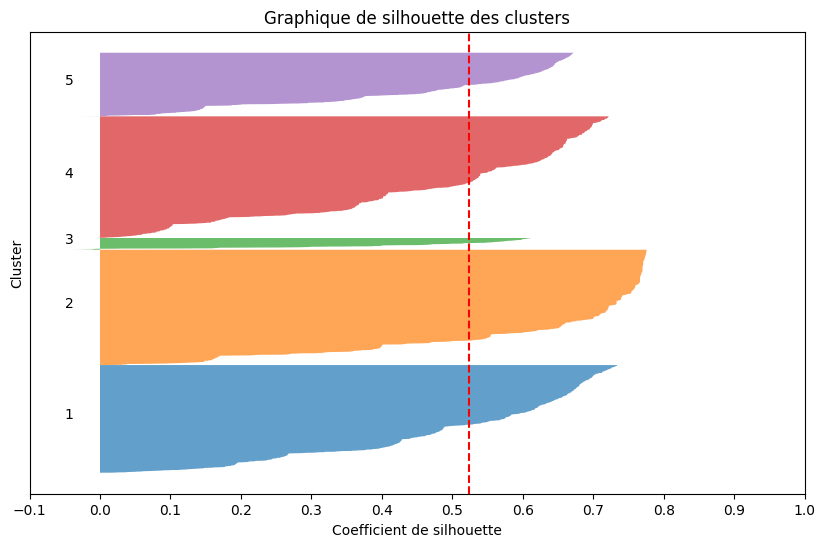

In [16]:
silhouette_vals = silhouette_samples(col_data, data['cluster'])
fig, ax = plt.subplots(figsize=(10, 6))
y_upper, y_lower = 0, 0
for i in range(n):
    cluster_silhouette_vals = silhouette_vals[data['cluster'] == i]
    cluster_silhouette_vals.sort()
    y_upper += len(cluster_silhouette_vals)
    ax.fill_betweenx(np.arange(y_lower, y_upper), 0, cluster_silhouette_vals, alpha=0.7)
    ax.text(-0.05, y_lower + 0.5 * len(cluster_silhouette_vals), str(i + 1))
    y_lower += len(cluster_silhouette_vals)
ax.axvline(x=silhouette_avg, color="red", linestyle="--")
ax.set_title("Graphique de silhouette des clusters")
ax.set_xlabel("Coefficient de silhouette")
ax.set_ylabel("Cluster")
ax.set_yticks([])
ax.set_xticks([-0.1, 0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1])
plt.show()

# Visualisation sur Carte

### Interprétation des clusters pour déterminer les catégories (petit, moyen, grand)


In [17]:
stats = data.groupby('cluster')[['haut_tot', 'haut_tronc', 'tronc_diam']].mean().reset_index()
def categorize(row, stats):
    if row['cluster'] == stats.loc[1, 'cluster']:
        return 'petit'
    elif row['cluster'] == stats.loc[3, 'cluster']:
        return 'petit'
    elif row['cluster'] == stats.loc[0, 'cluster']:
        return 'moyen'
    elif row['cluster'] == stats.loc[2, 'cluster']:
        return 'grand'
    elif row['cluster'] == stats.loc[4, 'cluster']:
        return 'grand'
    else:
        return 'inconnu'
data['category'] = data.apply(lambda row: categorize(row, stats), axis=1)
print(stats, "\n", data['category'].value_counts())

   cluster   haut_tot  haut_tronc  tronc_diam
0        0  14.028421    3.121053  133.877368
1        1   6.315634    2.013889   36.247788
2        2  21.700483    4.876812  268.579710
3        3  10.804753    2.775494   88.362069
4        4  17.283868    3.563280  181.178253 
 category
petit    4180
moyen    1900
grand    1329
Name: count, dtype: int64


### Création de la carte avec plotly et mise en forme avec mapbox en fonction de la catégorie choisie


In [18]:
def carte(cat):
    if cat in ['petit', 'moyen', 'grand']:
        cat_data = data[data['category'] == cat]
        fig = px.scatter_mapbox(cat_data, lat="latitude", lon="longitude", color="category", zoom=12)
        fig.update_layout(mapbox_style="open-street-map")
        fig.update_layout(margin={"r":0,"t":0,"l":0,"b":0})
        fig.show()
    elif cat == 'tout':
        fig = px.scatter_mapbox(data, lat="latitude", lon="longitude", color="category", zoom=12)
        fig.update_layout(mapbox_style="open-street-map")
        fig.update_layout(margin={"r":0,"t":0,"l":0,"b":0})
        fig.show()
    elif cat == 'anomalie':
        fig = px.scatter_mapbox(data, lat="latitude", lon="longitude", color="anomaly", zoom=12)
        fig.update_layout(mapbox_style="open-street-map")
        fig.update_layout(margin={"r":0,"t":0,"l":0,"b":0})
        fig.show()
    else:
        print("Catégorie invalide. Veuillez entrer : petit, moyen, grand, tout ou anomalie.")
        return

# Préparation du Script

### Choix du type de carte à afficher

In [19]:
category = input("Veuillez choisir une catégorie (petit, moyen, grand, tout, anomalie) : ")
carte(category)

ValueError: Mime type rendering requires nbformat>=4.2.0 but it is not installed